In [116]:
# https://github.com/evansdoe/online_retail/blob/main/online_retail.ipynb

## Importing relevant packages

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import plotly.express as px
import seaborn as sns

In [4]:
df = pd.read_csv('all_clean.csv')

In [6]:
df.sample(100000).to_csv('100_000.csv')

## Data engineering

In [120]:
#convert order date's datatype to pd.datetime
df.date = pd.to_datetime(df.date)

In [121]:
pd.DataFrame(df.customer_ID.describe())

,customer_ID
count,772116
unique,60848
top,9306ce8876e9632b14fffea5a56b57ce
freq,5537


## Exploring questions:

In [122]:
#1. How many online customers are there in the order?
len(df.customer_ID.unique())

60848

In [123]:
#2. customer genders?
pd.DataFrame(df.gender.describe())

,gender
count,772116
unique,3
top,female
freq,673832


In [124]:
#3. Calculate each month's revenue?
df['PurchaseYearMonth'] = df['date'].map(lambda date: 100*date.year + date.month)
ctm_revenue = df.groupby('PurchaseYearMonth').final_price.sum().reset_index()
ctm_revenue

,PurchaseYearMonth,final_price
0,202001,9371162.30
1,202002,7105533.11
2,202003,13391553.65
3,202004,8599789.50
4,202005,11644291.25
5,202006,13366172.20
6,202007,22090004.35
7,202008,13479019.66
8,202009,15027834.14
9,202010,18295516.31


In [125]:
ctm_bhvr_dt = df[(df.date < pd.Timestamp(2021,9,17)) & 
      (df.date >= pd.Timestamp(2020,1,2))].reset_index(drop=True)


ctm_next_quarter = df[(df.date < pd.Timestamp(2021,12,17)) & 
      (df.date >= pd.Timestamp(2021,9,17))].reset_index(drop=True)

In [126]:
# Get the distinct customers in the dataframe ctm_bhvr_dt
ctm_dt = pd.DataFrame(ctm_bhvr_dt['customer_ID'].unique())

# Rename the column to CustomerID.
ctm_dt.columns = ['customer_ID']

ctm_dt.describe()

,customer_ID
count,56770
unique,56770
top,623b30ace6407e07ba4e146b5a54e8c1
freq,1


In [127]:
# Create a dataframe with customer_ID and customers first purchase 
# date in ctm_next_quarter
ctm_1st_purchase_in_next_quarter = ctm_next_quarter.groupby('customer_ID').date.min().reset_index()
ctm_1st_purchase_in_next_quarter.columns = ['customer_ID','MinPurchaseDate']
ctm_1st_purchase_in_next_quarter.head()

,customer_ID,MinPurchaseDate
0,00023840107f83d05388db4002962cba,2021-10-05
1,0003d4accb349360abb3d6551d920c65,2021-11-05
2,0003f13066a5475477302f9ffb22773e,2021-11-13
3,0009d2e0a98f8c4d50846a2dd8c96bfc,2021-09-21
4,000b60a519cddafaddfc899256663980,2021-09-24


In [128]:
# Create a dataframe with customer_ID and customers last purchase
# date in ctm_bhvr_dt 
ctm_last_purchase_bhvr_dt = ctm_bhvr_dt.groupby('customer_ID').date.max().reset_index()
ctm_last_purchase_bhvr_dt.columns = ['customer_ID','MaxPurchaseDate']
ctm_last_purchase_bhvr_dt.head()

,customer_ID,MaxPurchaseDate
0,00023840107f83d05388db4002962cba,2020-05-10
1,0003f13066a5475477302f9ffb22773e,2020-08-28
2,0004138ef9a0e040dfe25164930da15e,2021-05-10
3,00048323ac3596c3fbf7b325c5a36dd3,2021-06-25
4,0006f9450e0b6308adb26f989cb88b2a,2021-07-10


In [129]:
# Merge two dataframes ctm_last_purchase_bhvr_dt and ctm_1st_purchase_in_next_quarter
ctm_purchase_dates = pd.merge(ctm_last_purchase_bhvr_dt, ctm_1st_purchase_in_next_quarter, on='customer_ID', 
                              how='left')
ctm_purchase_dates.head()
#we are using left merge becuase we only want customers with purchase history in the 2020.1.2 - 2021.9.16 time period

,customer_ID,MaxPurchaseDate,MinPurchaseDate
0,00023840107f83d05388db4002962cba,2020-05-10,2021-10-05
1,0003f13066a5475477302f9ffb22773e,2020-08-28,2021-11-13
2,0004138ef9a0e040dfe25164930da15e,2021-05-10,NaT
3,00048323ac3596c3fbf7b325c5a36dd3,2021-06-25,NaT
4,0006f9450e0b6308adb26f989cb88b2a,2021-07-10,NaT


In [130]:
# Let's calculate the time difference
ctm_purchase_dates['NextPurchaseDay'] = (ctm_purchase_dates['MinPurchaseDate'] - ctm_purchase_dates['MaxPurchaseDate']).dt.days
ctm_purchase_dates.head()

,customer_ID,MaxPurchaseDate,MinPurchaseDate,NextPurchaseDay
0,00023840107f83d05388db4002962cba,2020-05-10,2021-10-05,513.0
1,0003f13066a5475477302f9ffb22773e,2020-08-28,2021-11-13,442.0
2,0004138ef9a0e040dfe25164930da15e,2021-05-10,NaT,NaN
3,00048323ac3596c3fbf7b325c5a36dd3,2021-06-25,NaT,NaN
4,0006f9450e0b6308adb26f989cb88b2a,2021-07-10,NaT,NaN


In [131]:
# merge with ctm_dt 
ctm_dt = pd.merge(ctm_dt, ctm_purchase_dates[['customer_ID','NextPurchaseDay']], on='customer_ID', how='left')
ctm_dt.head()

,customer_ID,NextPurchaseDay
0,623b30ace6407e07ba4e146b5a54e8c1,6.0
1,425e1c86426147e286baaa3d5aabd2ca,NaN
2,eaea74b83345c37abbc7cfcba43549ed,NaN
3,05de55de3cced551eb0f88ba8771f8c0,41.0
4,1827f3d3db28a616232f0f3efccfef58,211.0


In [132]:
# update the dataframe filling the missing value

ctm_dt = ctm_dt.fillna(9999)
ctm_dt.head()

,customer_ID,NextPurchaseDay
0,623b30ace6407e07ba4e146b5a54e8c1,6.0
1,425e1c86426147e286baaa3d5aabd2ca,9999.0
2,eaea74b83345c37abbc7cfcba43549ed,9999.0
3,05de55de3cced551eb0f88ba8771f8c0,41.0
4,1827f3d3db28a616232f0f3efccfef58,211.0


__Recency__: Customers purchase behaviour based on their most recent purchase date and how many days they have been inactive since their last purchase.

__Frequency__: Customers purchase behaviour based on the number of times they buy from the online retail shop.

__Monetary Value/Revenue__: Customers purchase behaviour based the revenue they generate.

After we will apply K-means clustering to assign customers a score to each of the features.

## Recency

In [133]:
ctm_max_purchase = ctm_bhvr_dt.groupby('customer_ID').date.max().reset_index()
ctm_max_purchase.columns = ['customer_ID','MaxPurchaseDate']
ctm_max_purchase.head()

,customer_ID,MaxPurchaseDate
0,00023840107f83d05388db4002962cba,2020-05-10
1,0003f13066a5475477302f9ffb22773e,2020-08-28
2,0004138ef9a0e040dfe25164930da15e,2021-05-10
3,00048323ac3596c3fbf7b325c5a36dd3,2021-06-25
4,0006f9450e0b6308adb26f989cb88b2a,2021-07-10


In [134]:
# Find the recency in days 
ctm_max_purchase['Recency'] = (ctm_max_purchase['MaxPurchaseDate'].max() - ctm_max_purchase['MaxPurchaseDate']).dt.days

# Merge the dataframes ctm_dt and ctm_max_purchase[['CustomerID', 'Recency']] on the CustomerID column.
ctm_dt = pd.merge(ctm_dt, ctm_max_purchase[['customer_ID', 'Recency']], on='customer_ID')
ctm_dt.head()

,customer_ID,NextPurchaseDay,Recency
0,623b30ace6407e07ba4e146b5a54e8c1,6.0,2
1,425e1c86426147e286baaa3d5aabd2ca,9999.0,14
2,eaea74b83345c37abbc7cfcba43549ed,9999.0,406
3,05de55de3cced551eb0f88ba8771f8c0,41.0,8
4,1827f3d3db28a616232f0f3efccfef58,211.0,142


In [135]:
ctm_max_purchase['MaxPurchaseDate'].max()

Timestamp('2021-09-16 00:00:00')

In [136]:
pd.DataFrame(ctm_dt.Recency.describe())

,Recency
count,56770.000000
mean,198.790277
std,166.671204
min,0.000000
25%,46.000000
50%,170.000000
75%,333.000000
max,622.000000


### Elbow method - 4

/var/folders/86/dkx02css7094lzgc17d9_9n00000gn/T/ipykernel_11318/4204577450.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/86/dkx02css7094lzgc17d9_9n00000gn/T/ipykernel_11318/4204577450.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/86/dkx02css7094lzgc17d9_9n00000gn/T/ipykernel_11318/4204577450.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

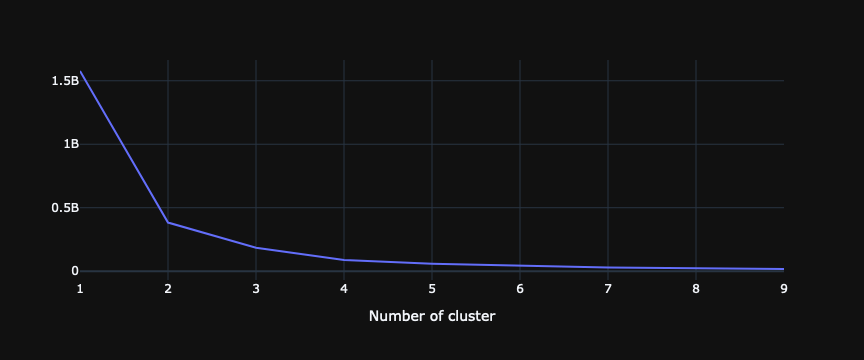

In [137]:
my_dict={}
ctm_recency = ctm_dt[['Recency']]
for idx in range(1, 10):
    kmeans = KMeans(n_clusters=idx, max_iter=1000).fit(ctm_recency)
    ctm_recency["clusters"] = kmeans.labels_
    my_dict[idx] = kmeans.inertia_ 

line_fig = px.line(x=list(my_dict.keys()), 
                   y=list(my_dict.values()), 
                   template="plotly_dark"
                  )

line_fig.update_layout(title_x=0, 
                       xaxis_title="Number of cluster", 
                       yaxis_title=""
                      )

line_fig.show(config={'displaylogo': False})

In [138]:
number_of_clusters = 4

In [139]:
kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.fit(ctm_dt[['Recency']])
ctm_dt['RecencyCluster'] = kmeans.predict(ctm_dt[['Recency']])
ctm_dt.head()

,customer_ID,NextPurchaseDay,Recency,RecencyCluster
0,623b30ace6407e07ba4e146b5a54e8c1,6.0,2,0
1,425e1c86426147e286baaa3d5aabd2ca,9999.0,14,0
2,eaea74b83345c37abbc7cfcba43549ed,9999.0,406,2
3,05de55de3cced551eb0f88ba8771f8c0,41.0,8,0
4,1827f3d3db28a616232f0f3efccfef58,211.0,142,3


In [140]:
ctm_dt.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,21019.0,33.048718,28.767167,0.0,6.0,26.0,56.0,102.0
1,7735.0,495.110407,58.509481,415.0,443.0,479.0,549.0,622.0
2,12102.0,333.524541,42.596773,253.0,302.0,340.0,364.0,414.0
3,15914.0,171.212769,37.858343,103.0,139.0,174.0,193.0,252.0


## Frequency

In [141]:
#get order counts for each user and create a dataframe with it
ctm_frequency = df.groupby('customer_ID').date.count().reset_index()
ctm_frequency.columns = ['customer_ID','Frequency']

In [142]:
ctm_frequency

,customer_ID,Frequency
0,00023840107f83d05388db4002962cba,4
1,0003d4accb349360abb3d6551d920c65,1
2,0003f13066a5475477302f9ffb22773e,6
3,0004138ef9a0e040dfe25164930da15e,7
4,00048323ac3596c3fbf7b325c5a36dd3,3
...,...,...
60843,fffa8df58b92f83a30b31f3a995ec88f,13
60844,fffb07fdf90bb49633458d40ad3d7c98,13
60845,fffb3f6d92d14f4c213acc679929f9ec,10
60846,fffc873e6028b08ff391273f9518548a,3


In [143]:
ctm_dt = pd.merge(ctm_dt, ctm_frequency, on = 'customer_ID')

In [144]:
ctm_dt,
pd.DataFrame(ctm_dt.Frequency.describe())

,Frequency
count,56770.000000
mean,13.395631
std,41.444661
min,1.000000
25%,2.000000
50%,5.000000
75%,12.000000
max,5537.000000


### Elbow method - 4

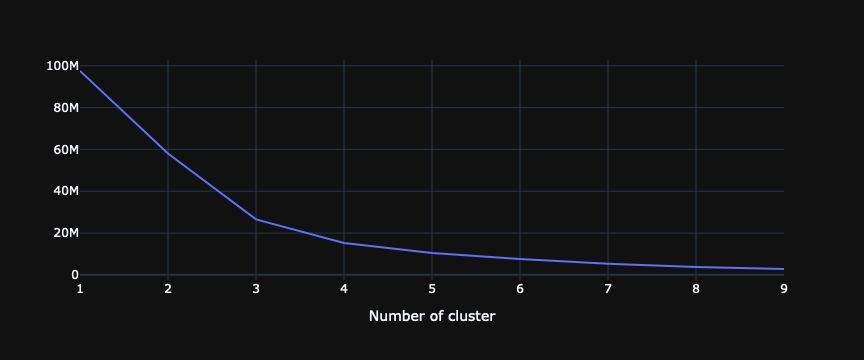

In [145]:
my_dict={}
ctm_frequency = ctm_dt[['Frequency']]
for idx in range(1, 10):
    kmeans = KMeans(n_clusters=idx, max_iter=1000).fit(ctm_frequency)
    ctm_recency["clusters"] = kmeans.labels_
    my_dict[idx] = kmeans.inertia_ 

line_fig = px.line(x=list(my_dict.keys()), 
                   y=list(my_dict.values()), 
                   template="plotly_dark"
                  )

line_fig.update_layout(title_x=0, 
                       xaxis_title="Number of cluster", 
                       yaxis_title=""
                      )

line_fig.show(config={'displaylogo': False})

In [146]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(ctm_dt[['Frequency']])
ctm_dt['FrequencyCluster'] = kmeans.predict(ctm_dt[['Frequency']])
ctm_dt.head()

,customer_ID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster
0,623b30ace6407e07ba4e146b5a54e8c1,6.0,2,0,70,0
1,425e1c86426147e286baaa3d5aabd2ca,9999.0,14,0,33,1
2,eaea74b83345c37abbc7cfcba43549ed,9999.0,406,2,6,1
3,05de55de3cced551eb0f88ba8771f8c0,41.0,8,0,228,3
4,1827f3d3db28a616232f0f3efccfef58,211.0,142,3,70,0


In [147]:
ctm_dt.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3244.0,78.027435,34.600404,43.0,52.00,66.0,93.25,194.0
1,53216.0,7.562801,8.339850,1.0,2.00,4.0,10.00,42.0
2,2.0,4456.500000,1528.057754,3376.0,3916.25,4456.5,4996.75,5537.0
3,308.0,311.603896,132.100565,195.0,225.00,267.5,334.50,917.0


## Revenue

In [148]:
ctm_revenue = df.groupby('customer_ID').final_price.sum().reset_index()

In [149]:
ctm_dt = pd.merge(ctm_dt, ctm_revenue, on = 'customer_ID')

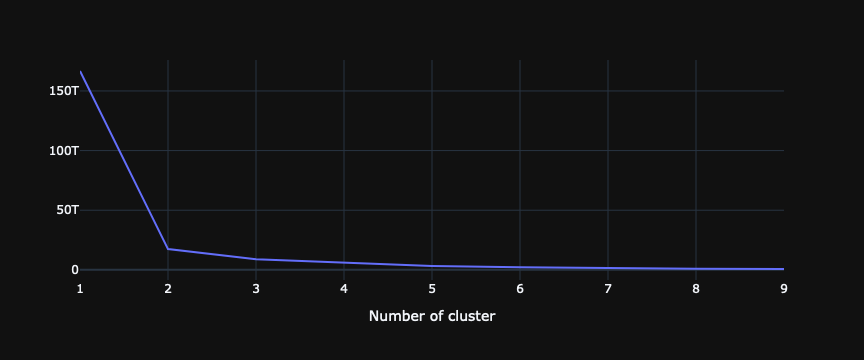

In [150]:
my_dict={}
ctm_revenue = ctm_dt[['final_price']]
for idx in range(1, 10):
    kmeans = KMeans(n_clusters=idx, max_iter=1000).fit(ctm_revenue)
    ctm_recency["clusters"] = kmeans.labels_
    my_dict[idx] = kmeans.inertia_ 

line_fig = px.line(x=list(my_dict.keys()), 
                   y=list(my_dict.values()), 
                   template="plotly_dark"
                  )

line_fig.update_layout(title_x=0, 
                       xaxis_title="Number of cluster", 
                       yaxis_title=""
                      )

line_fig.show(config={'displaylogo': False})

In [183]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(ctm_dt[['final_price']])
ctm_dt['RevenueCluster'] = kmeans.predict(ctm_dt[['final_price']])
ctm_dt.head()

,customer_ID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,final_price,RevenueCluster
0,623b30ace6407e07ba4e146b5a54e8c1,6.0,2,0,70,0,20845.50,0
1,425e1c86426147e286baaa3d5aabd2ca,9999.0,14,0,33,1,16302.95,0
2,eaea74b83345c37abbc7cfcba43549ed,9999.0,406,2,6,1,3158.00,0
3,05de55de3cced551eb0f88ba8771f8c0,41.0,8,0,228,3,119137.08,3
4,1827f3d3db28a616232f0f3efccfef58,211.0,142,3,70,0,40912.70,3


### Elbow method - 2

In [184]:
ctm_dt

,customer_ID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,final_price,RevenueCluster
0,623b30ace6407e07ba4e146b5a54e8c1,6.0,2,0,70,0,20845.50,0
1,425e1c86426147e286baaa3d5aabd2ca,9999.0,14,0,33,1,16302.95,0
2,eaea74b83345c37abbc7cfcba43549ed,9999.0,406,2,6,1,3158.00,0
3,05de55de3cced551eb0f88ba8771f8c0,41.0,8,0,228,3,119137.08,3
4,1827f3d3db28a616232f0f3efccfef58,211.0,142,3,70,0,40912.70,3
...,...,...,...,...,...,...,...,...
56765,054e1a62d23d09e72d38c4075bcc45e4,9999.0,4,0,4,1,541.00,0
56766,661ab21051c5bdd0be39b91e0c21bb15,9999.0,4,0,1,1,200.00,0
56767,cf88ab6e7a7774bb3750a136a16a7f36,9999.0,4,0,1,1,975.00,0
56768,7a9bb7ffac170a4e12c7ae4562ac5f88,9999.0,4,0,1,1,560.00,0


## Kmeans analysis

In [185]:
ctm_dt.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3244.0,78.027435,34.600404,43.0,52.00,66.0,93.25,194.0
1,53216.0,7.562801,8.339850,1.0,2.00,4.0,10.00,42.0
2,2.0,4456.500000,1528.057754,3376.0,3916.25,4456.5,4996.75,5537.0
3,308.0,311.603896,132.100565,195.0,225.00,267.5,334.50,917.0


In [186]:
ctm_dt.groupby('RevenueCluster')['final_price'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,54717.0,3.516141e+03,4629.718455,0.00,7.000000e+02,1700.00,4192.75,27468.10
1,1.0,1.222522e+07,NaN,12225217.30,1.222522e+07,12225217.30,12225217.30,12225217.30
2,155.0,2.228531e+05,152364.136716,137399.85,1.565841e+05,181713.20,240769.75,1800830.00
3,1897.0,5.146926e+04,24333.810538,27482.40,3.341090e+04,42928.25,60416.10,135894.15


<AxesSubplot:xlabel='final_price', ylabel='Count'>

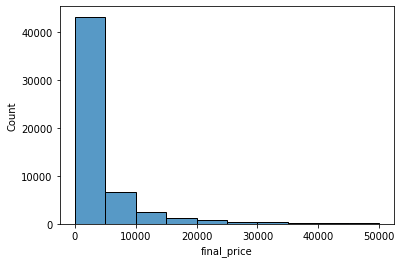

In [189]:
sns.histplot(data=ctm_dt[ctm_dt.final_price < 50000], x="final_price",bins = 10)